## Intro

Fastai2 provides a wide range of data augmentation techniques and this blog is particularly focused on image 
augmentation techniques (This is a update to the article 'Data Augmentation Techniques' I wrote in 2018 using fastai v1[1] 

Working with limited data has its own challenges, using data augmentation can have positive results only 
if the augmentation techniques enhance the current data set for example is there any worth is training a 
network to ‘learn’ about a landmark in a flipped upside down orientation?

[Image - Ben]

Invariance is the ability of convolutional neural networks to classify objects even when they are placed in different 
orientations. Data augmentation is a way of creating new ‘data’ with different orientations. The benefits of this are 
two fold, the first being the ability to generate ‘more data’ from limited data and secondly it prevents over fitting.

Most deep learning libraries use a step by step method of augmentation whilst fastai2 utilizes methods that combine various 
augmentation parameters to reduce the number of computations and reduce the number of lossy operations[2]

Lets take a deeper look at how fastai2 does its image augmentations>>>

Fastai uses Pipelines to compose several transforms together.  A Pipeline is defined by passing a list of Transforms and it will then compose the transforms inside it.  In this blog I will look at what order these transforms are conducted and what effect they have on image quality and efficiency.

Using this as an example

In [32]:
from fastai2.vision.all import*

In [203]:
#High-level API example
source = untar_data(URLs.PETS)

testblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=[Resize(256)],
                 batch_tfms=[*aug_transforms(xtra_tfms=None)])
test_dls = testblock.dataloaders(source/'images')

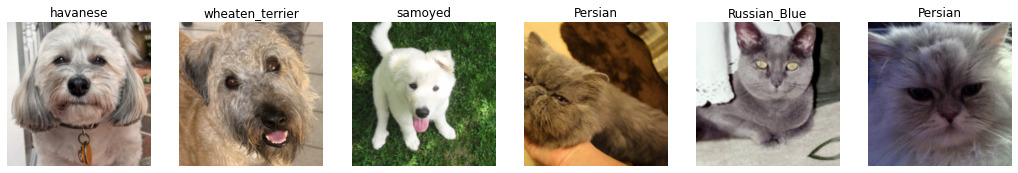

In [169]:
test_dls.show_batch(max_n=6, nrows=1, ncols=6)

To check the order of how augementations are conducted we can call test_dls.after_item and test_dls.after_batch

### after_item

In [6]:
test_dls.after_item

Pipeline: Resize -> ToTensor

In this case images are:
> resized to sizes of equal length, in this case 256 and then

> collated into tensors in order for them to be passed onto a GPU

### But what does Resize do?

By default resize 'squishes' the image to the size specified. The image is resized so that the shorter dimension matches
the size specifed and the rest padded with what is specified in pad_mode.  By default fastai uses crop as the resize method.
The method parameter can be be 1 of 3 values: Crop, Pad or Squish(default) eg: method=ResizeMethod.Squish
The padding parameter also takes 1 of 3 values: Border, Zeros and Reflection(default)  eg: pad_mode=PadMode.Reflection.

The images are resized/resamples using bilinear and nearest neighbour interprolations[3]

We can check to see how initial image sizes are affected by Resize. I choose an image with numbers so that you can see
different areas of the image easier and I colored each of the corners a different color to better see what effects 
Resize has on the image.

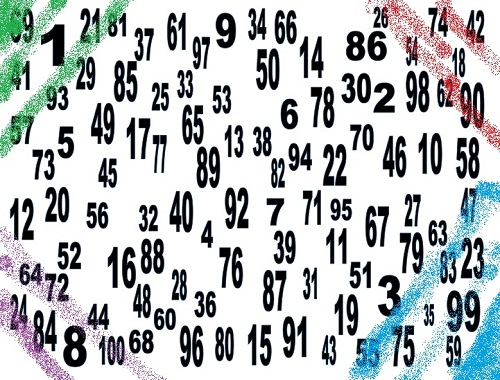

In [89]:
#Open a test image
image_path = 'C:/Users/avird/.fastai/data/0100-number_12.jpg'
img = Image.open(image_path)
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())
t = _batch_ex(8)
img = PILImage(PILImage.create(image_path).resize((500,380)))
img

In [90]:
img.size #width/height

(500, 380)

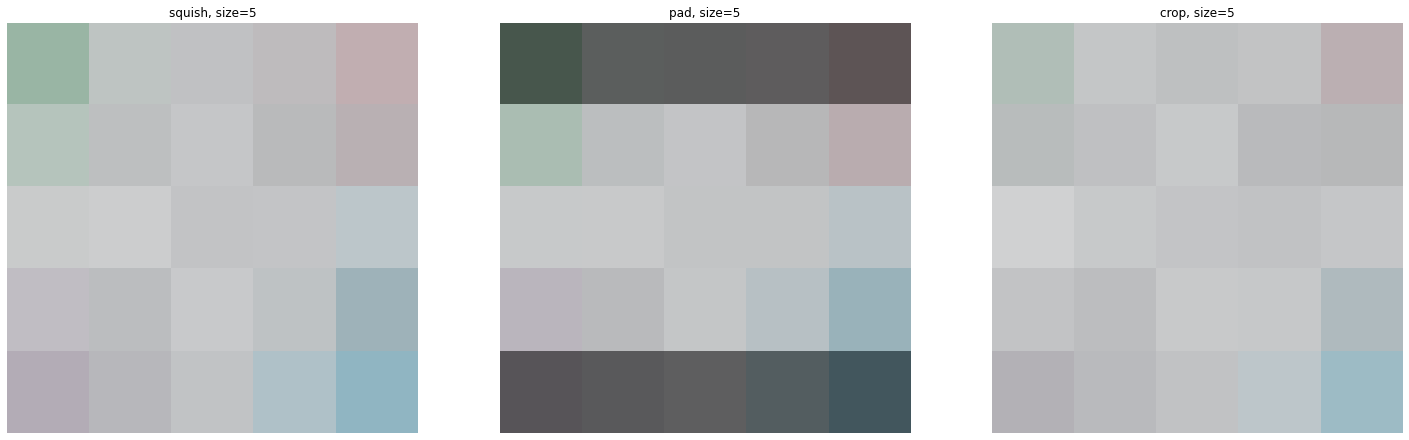

In [135]:
#plot 1 image each for each of the 3 types of ResizeMethod (Squish is default). For Padding I changed to PadMode.Zeros
#(default is Reflection)
#Use image size of 5
_,axs = plt.subplots(1,3,figsize=(25,25))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(5, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=1), ctx=ax, title=f'{method}, size=5');

In [ ]:
Using an image size of 5 we can see how the image is affected by Resize. Here is we can still see the 4 different colors
in each corner.  With pad we can see that the image is being resized so the shorter dimension is matched to the image size
and then padded with zeros. With crop the image is cropped from the center.

Note: A RandTransform is only applied to the training set by default, so you have to pass split_idx=0 if you are calling it directly and not through a Datasets. That behavior can be changed by setting the attr split_idx of the transform to None.

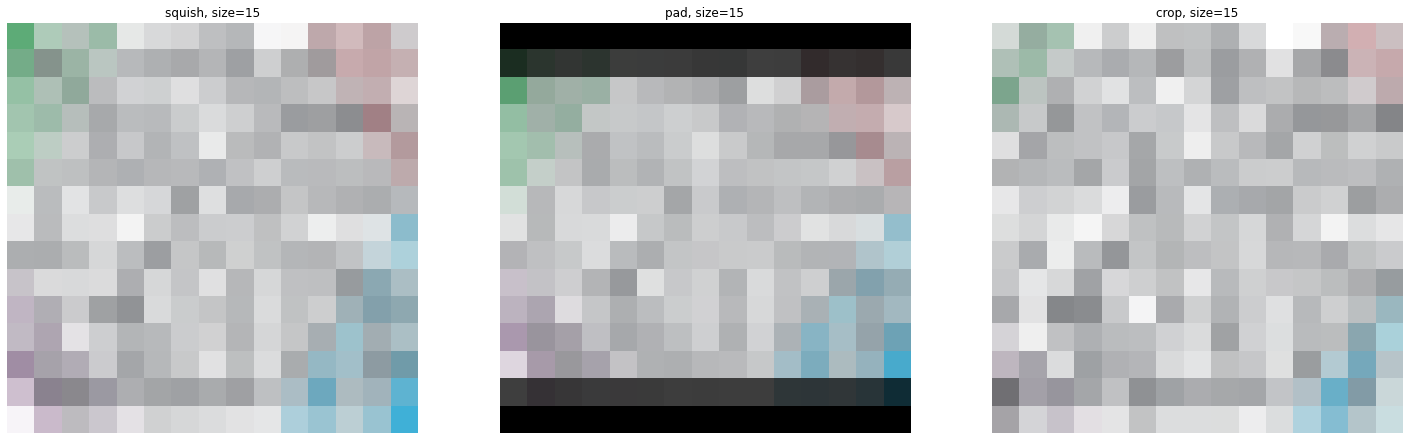

In [134]:
#Use image size of 15
_,axs = plt.subplots(1,3,figsize=(25,25))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(15, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=1), ctx=ax, title=f'{method}, size=15');

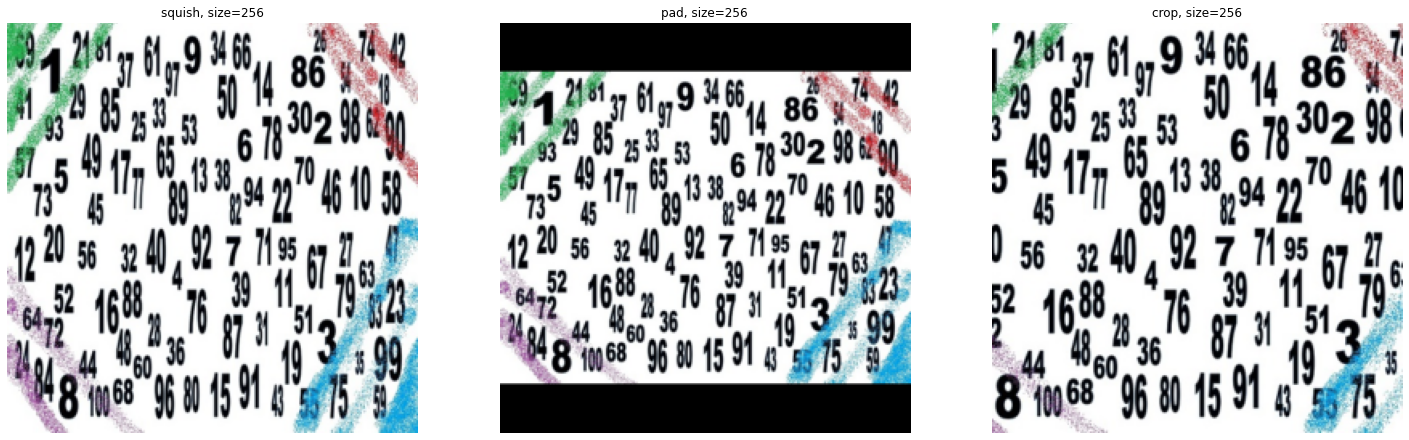

In [133]:
#Use image size of 256
_,axs = plt.subplots(1,3,figsize=(25,25))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=1), ctx=ax, title=f'{method}, size=256');

What impacts could this have on real datasets.

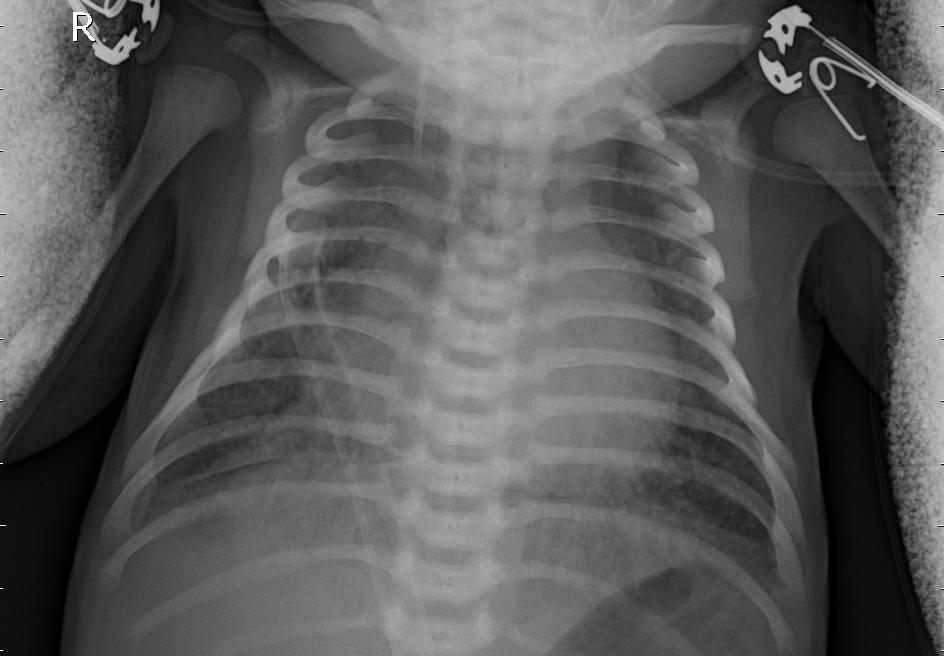

In [109]:
test_path = 'C:/Users/avird/.fastai/data/0002.jpeg'
testimg = Image.open(test_path)
timg2 = TensorImage(array(testimg)).permute(-2,1).float()/255. #change for jpeg
def _batch_ex(bs): return TensorImage(timg2[None].expand(bs, *timg2.shape).clone())
t = _batch_ex(8)
img2 = PILImage(PILImage.create(test_path).resize((944, 656)))
img2

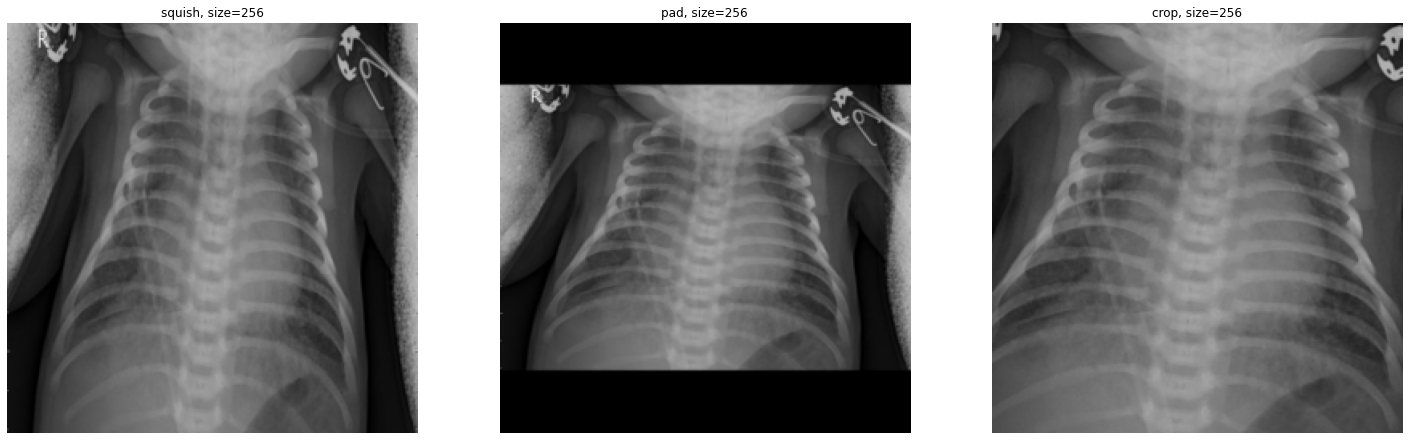

In [132]:
#Use image size of 256
_,axs = plt.subplots(1,3,figsize=(25,25))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img2, split_idx=1), ctx=ax, title=f'{method}, size=256');

In this case the default squish resize method squishes the image on the horizontal axis, for the pad resize the image 
has been squished on the vertical axis and in the crop method parts of the image have been cropped.

### after_batch

Back to the pets example if we run dls.after_batch this will show us the after batch augmentation pipeline.  Previously item_tfms is used to resize the images and to collate them into tensors ready for GPU processing.

In [137]:
test_dls.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

This reveals the pipeline process for the batch transformations:
> convert ints to float tensors

> apply all the affine transformations

> followed by the lighting transformations.  

The order is important in order to maintain a number of key aspects:

> Maintain image quality

> Reduce computations

> Improve efficiency

As mentioned in Fastbook[4], most machine libraries use a step by step process of augmentation which can lead to a reduced quality of images.  The datablock example above is an example of a high-level API which is pretty flexible but not as much as a mid-level API. 

The mid-level datablock below is an exact example of the high-level datablock above and allows for more customizations.

In [324]:
#Helper for viewing single images
def repeat_one(source, n=128):
    """Single image helper for displaying batch"""
    return [get_image_files(source)[0]]*n

In [321]:
#mid-level API example 
#num_workers = 0 because I use windows :) and windows does not support multiprocessing on CUDA
tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(256)]
splitter=RandomSplitter(seed=42)
after_b = [IntToFloatTensor(), *aug_transforms(xtra_tfms=None)]

dsets = Datasets(repeat_one(source/'images'), tfms=tfms)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

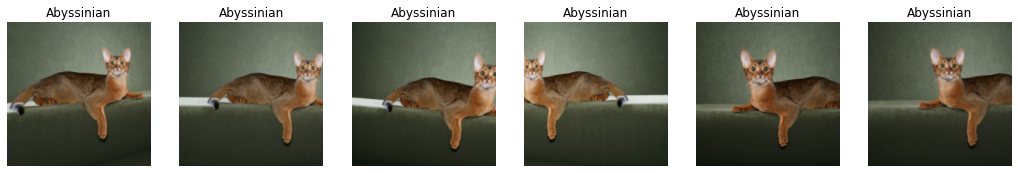

In [188]:
dls.show_batch(max_n=6, nrows=1, ncols=6)

### Image comparisons (Fastai v The Rest)

In [189]:
#create 1 batch
x,y = dls.one_batch()

Lets check image quality and speed using step by step transformations

Wall time: 103 ms


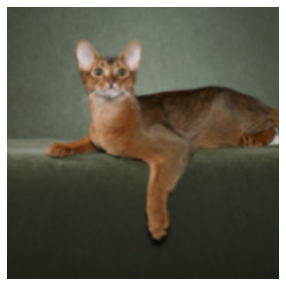

In [198]:
%%time
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=256)
x1 = x1.brightness(max_lighting=0.2, p=1.)
x1 = x1.zoom(max_zoom=1.1, p=0.5)
x1 = x1.warp(magnitude=0.2, p=0.5)

_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x1[0]).show(ctx=axs[0])

Wall time: 45.9 ms


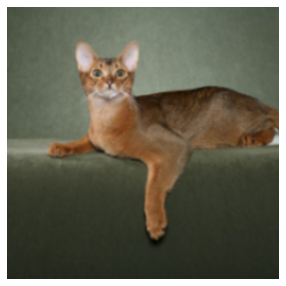

In [199]:
%%time
tfms = setup_aug_tfms([Brightness(max_lighting=0.2, p=1.,),
                       CropPad(size=256),
                       Zoom(max_zoom=1.1, p=0.5),
                       Warp(magnitude=0.2, p=0.5)
                      ])
x = Pipeline(tfms)(x)
_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x[0]).show(ctx=axs[0])

Comparing the times above using a pipeline where a list of transforms are passed in is nearly twice as fast as using augmentations step by step. In this case the step by step method completed the task in 103ms compard to 46s using fastai

Lets take a side by side look at image quality

In [276]:
def image_comp():
    x,y = dls.one_batch()
    tfms = setup_aug_tfms([Brightness(max_lighting=0.3, p=1.,),
                       Resize(size=256),
                       Zoom(max_zoom=1.1, p=1.),
                       Warp(magnitude=0.2, p=1.)
                      ])
    x = Pipeline(tfms)(x)

    x1 = TensorImage(x.clone())
    x1 = x1.affine_coord(sz=256)
    x1 = x1.brightness(max_lighting=0.3, p=1.)
    x1 = x1.zoom(max_zoom=1.1, p=1.)
    x1 = x1.warp(magnitude=0.2, p=1.)

    _,axs = subplots(1, 2, figsize=(25,25))
    TensorImage(x[0]).show(ctx=axs[0], title='fastai')
    TensorImage(x1[0]).show(ctx=axs[1], title='other')

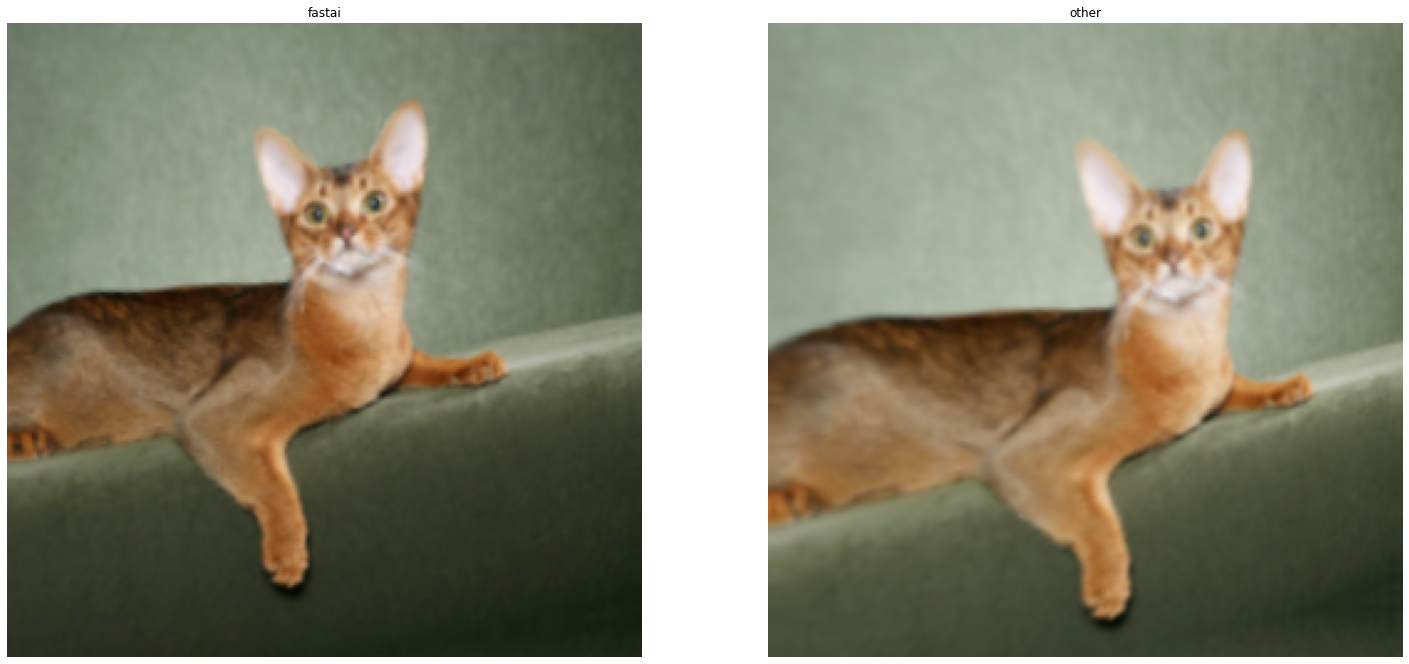

In [277]:
image_comp()

You can definately see differences between the two pictures, the 'fastai' image is more clearer compared to the 'other' image.  How about other examples

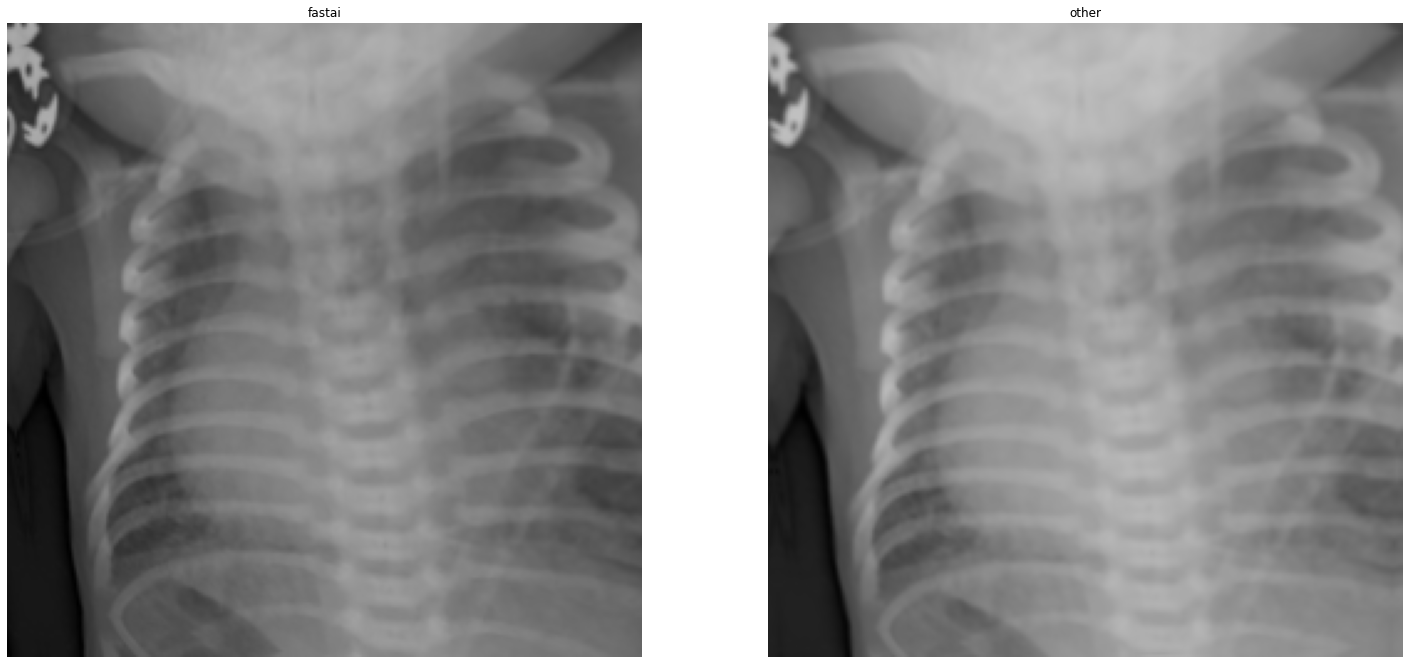

In [284]:
image_comp()

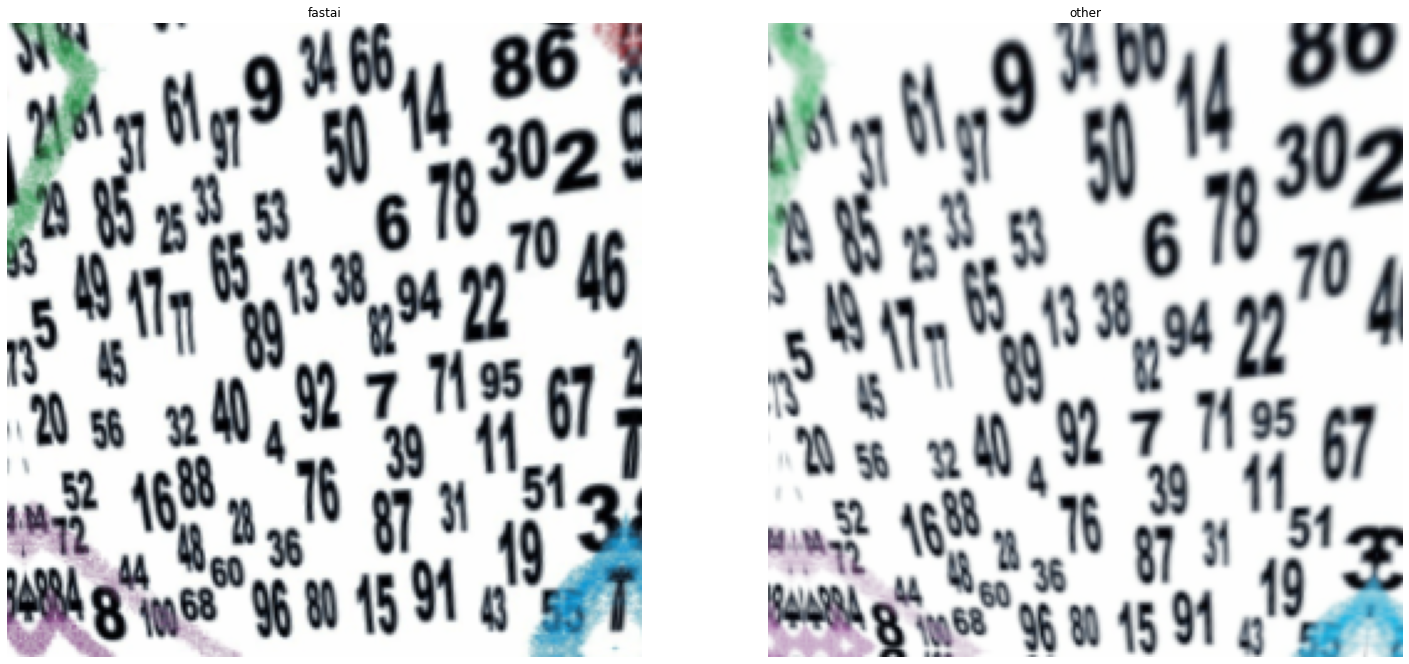

In [288]:
image_comp()

Its clear to see that the augmentations using fastai are clearer compared to the other method

### Pipeline for multiple augmentations

In the example above the after_batch pipeline consisted of IntToFloatTensor > Affine tranformations > Lighting transformations.  What if we use numerous augmentations, what does the pipeline look like then?

In [372]:
source = untar_data(URLs.PETS)
#Helper for viewing single images
def repeat_one(source, n=128):
    """Single image helper for displaying batch"""
    return [get_image_files(source)[2]]*n

In [436]:
#Include multiple transforms  using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')
tfms = [[PILImage.create], [parent_label, Categorize]]
item_tfms = [ToTensor(), Resize(296)]
splitter=RandomSplitter(seed=42)
xtra_tfms = [Rotate(max_deg=45, p=1.),
            RandomErasing(p=1., max_count=10, min_aspect=0.5, sl=0.2, sh=0.2),
            RandomResizedCrop(p=1., size=256),
            Brightness(max_lighting=0.2, p=1.),
            CropPad(size=256),
            Zoom(max_zoom=2.1, p=0.5),
            Warp(magnitude=0.2, p=1.0)
            ]
after_b = [IntToFloatTensor(), *aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=0., 
           max_zoom=1.1, max_lighting=0.,max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=xtra_tfms, size=256,
           mode='bilinear', pad_mode=pad_mode, align_corners=True, batch=False)]

mdsets = Datasets(repeat_one(source/'images'), tfms=tfms)
mdls = mdsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

Looking at after_item - it is the same as before

In [429]:
mdls.after_item

Pipeline: Resize -> ToTensor

In [430]:
mdls.after_batch

Pipeline: CropPad -> IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> RandomErasing

after_batch is now a different story and we can see the list of how fastai computes its augmentations.  These are all done in sequence (depending on their order) starting with CropPad, followed by affine, lighting and random erasing transforms. Here is what the batch looks like

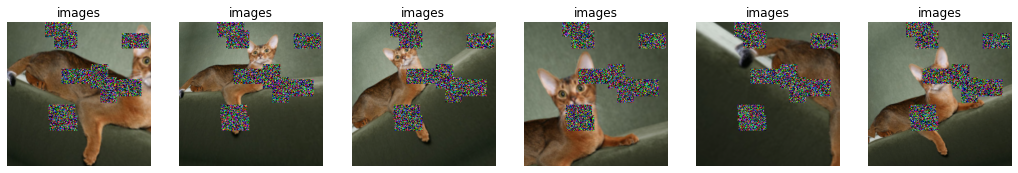

In [431]:
mdls.show_batch(max_n=6, nrows=1, ncols=6)

The order number determines the sequence of the transforms for example CropPad is order 0, Resize and RandomCrop are order 1 hence the reason they appear first on the list.  Affine transforms are order 30 and so is RandomResizedCropGPU and lighting transforms are order 40.

### Interesting Observations

There were some interesting observations during this experimention. Adding a min_scale value in aug_transforms adds RandomResizedCropGPU to the pipeline

In [433]:
mdls.after_batch

Pipeline: CropPad -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> RandomErasing

However if you add RandomResizedCrop as well as a min_scale value the pipeline now looks like this

In [435]:
mdls.after_batch

Pipeline: RandomResizedCrop -> CropPad -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> RandomErasing

And if you use RandomResizedCrop with no min_scale value the pipeline is now:

In [437]:
mdls.after_batch

Pipeline: RandomResizedCrop -> CropPad -> IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> RandomErasing

### Still to do

There is clearly a plethora of options and additonal experimentation is needed to see what the impact of the various pipelines are on image quality, efficiency and end results

### Manually going through the pipeline

In [545]:
xtra_tfms = ([Brightness(max_lighting=0.2, p=1.,),
              CropPad(size=256),
              Contrast(max_lighting=0.5, p=1., draw=0.25),
              RandomErasing(p=1., max_count=10, min_aspect=0.5, sl=0.2, sh=0.2),
              ])

tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(256)]
splitter=RandomSplitter(seed=42)
after_b = [IntToFloatTensor(), *aug_transforms(xtra_tfms=xtra_tfms)]

tsets = Datasets(repeat_one(source/'images'), tfms=tfms)
tls = tsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

In [546]:
tls.after_batch

Pipeline: CropPad -> IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> RandomErasing

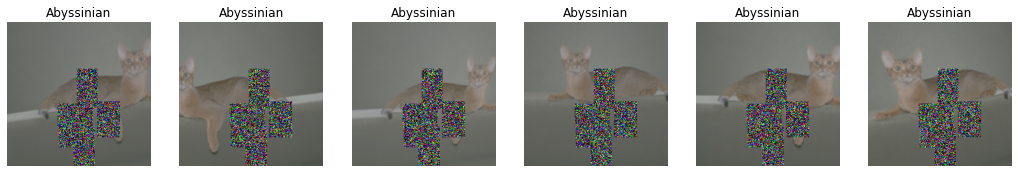

In [547]:
tls.show_batch(max_n=6, nrows=1, ncols=6)

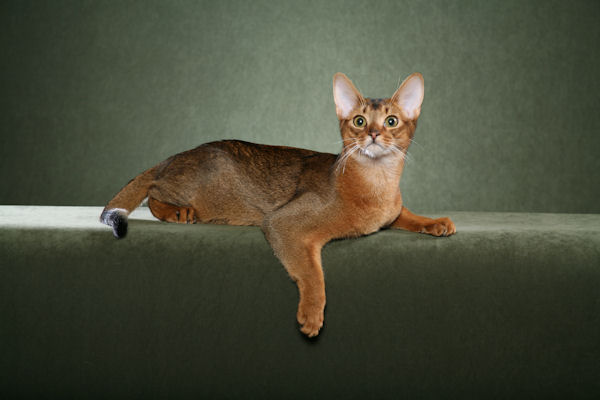

In [467]:
image_path = 'C:/Users/avird/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'
img = Image.open(image_path)
#img = get_image_files(source/'images')[2]
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())
t = _batch_ex(8)
img = PILImage(PILImage.create(image_path).resize((600,400)))
img

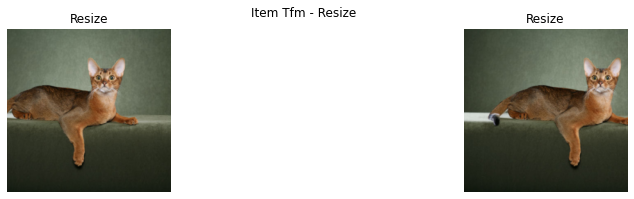

In [521]:
re = Resize(256)
fig,axs = plt.subplots(1,2, figsize=(15,3))
fig.suptitle('Item Tfm - Resize')
for i,ax in enumerate(axs.flatten()):
    show_image(re(img), ctx=ax, title='Resize')

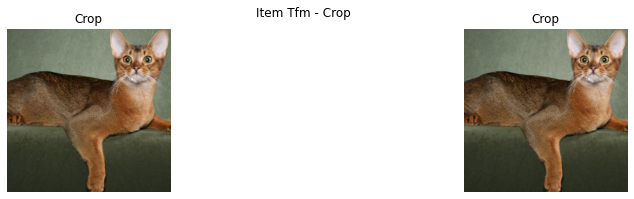

In [581]:
crp = CropPad((256))
fig,axs = plt.subplots(1,2, figsize=(15,3))
fig.suptitle('Item Tfm - Crop')
for i,ax in enumerate(axs.flatten()):
    tfm = res(crp(img))
    show_image(tfm, ctx=ax, title='Crop')

### References:
  
[1] = https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b) 

[2] = https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb

[3] = https://github.com/fastai/fastai2/blob/master/nbs/09_vision.augment.ipynb

[4] = https://github.com/fastai/fastbook